In [68]:
from requests import get
from bs4 import BeautifulSoup
from time import sleep,time
from random import randint
from warnings import warn
import pandas as pd



In [60]:
# page range from 1 to 4
pages = [str(i) for i in range(1,5)]

# year range from 2015 to 2018
years_url = [str(i) for i in range(2015,2018)]

# accept only english language page
headers = {"Accept-Language": "en-US, en"}

# list of fields 
names=[]
years=[]
ratings=[]
metascores=[]
votes=[]

In [61]:
def extract_fields(div_list):
    for movie_div in div_list:
        if movie_div.find('div',class_="ratings-metascore") is not None:
            names.append(movie_div.h3.a.text)
            years.append(movie_div.h3.find_all('span')[1].text)
            ratings.append(float(movie_div.strong.text))
            metascores.append(int(movie_div.find('span',class_="metascore").text))
            votes.append(int(movie_div.find('span', attrs = {'name':'nv'})['data-value']))
            #print("{:50s} {:15s} {:5s} {:3s} {:7s}".format(movie_name,movie_year,movie_rating,movie_metascore,movie_votes))

In [65]:
# Preparing the monitoring of the loop
start_time = time()
requests = 0

# For every year in the interval 2015-2017
for year_url in years_url:

    # For every page in the interval 1-4
    for page in pages:
        
        # Make a get request
        response = get('http://www.imdb.com/search/title?release_date=' + year_url +'&sort=num_votes,desc&page=' + page, headers = headers)
        
        # Pause the loop
        sleep(randint(8,15))

        # Monitor the requests
        requests += 1
        elapsed_time = time() - start_time
        print('Request:{}; Frequency: {} requests/s'.format(requests, requests/elapsed_time))
        
        # Throw a warning for non-200 status codes
        if response.status_code != 200:
            warn('Request: {}; Status code: {}'.format(requests, response.status_code))

        # Break the loop if the number of requests is greater than expected
        if requests > 72:
            warn('Number of requests was greater than expected.')
            break
            
        # Parse the content of the request with BeautifulSoup
        page_html = BeautifulSoup(response.text, 'html.parser')
        
        # Select all the 50 movie containers from a single page
        movie_div_list = page_html.find_all('div', class_ = 'lister-item mode-advanced')
        
        extract_fields(movie_div_list)
        

Request:1; Frequency: 0.05902331902259965 requests/s
Request:2; Frequency: 0.07020471677897994 requests/s
Request:3; Frequency: 0.06538817640470042 requests/s
Request:4; Frequency: 0.06716426188917733 requests/s
Request:5; Frequency: 0.0649708208596798 requests/s
Request:6; Frequency: 0.06871539174485748 requests/s
Request:7; Frequency: 0.0696226609087333 requests/s
Request:8; Frequency: 0.06783784514227682 requests/s
Request:9; Frequency: 0.06854833280250935 requests/s
Request:10; Frequency: 0.06832634056158852 requests/s
Request:11; Frequency: 0.06973349848760359 requests/s
Request:12; Frequency: 0.06815505989041841 requests/s


In [67]:
print(len(names),len(years),len(ratings),len(metascores),len(votes))

532 532 532 532 532


In [69]:
movie_df = pd.DataFrame({'movie': names,
'year': years,
'imdb': ratings,
'metascore': metascores,
'votes': votes
})
movie_df.loc[:, 'year'] = movie_df['year'].str[-5:-1].astype(int)
print(movie_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532 entries, 0 to 531
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   movie      532 non-null    object 
 1   year       532 non-null    int32  
 2   imdb       532 non-null    float64
 3   metascore  532 non-null    int64  
 4   votes      532 non-null    int64  
dtypes: float64(1), int32(1), int64(2), object(1)
memory usage: 18.8+ KB
None


In [75]:
movie_df.head(10)

,movie,year,imdb,metascore,votes
0,Mad Max: Fury Road,2015,8.1,90,879802
1,Star Wars: Episode VII - The Force Awakens,2015,7.9,80,859406
2,The Martian,2015,8.0,80,758306
3,Avengers: Age of Ultron,2015,7.3,66,739207
4,The Revenant,2015,8.0,76,703471
5,Inside Out,2015,8.1,94,613917
6,Jurassic World,2015,7.0,59,578485
7,Ant-Man,2015,7.3,64,568575
8,The Hateful Eight,2015,7.8,68,515128
9,Spotlight,2015,8.1,93,419019


In [72]:
movie_df.to_csv('IMDB_movie_ratings.csv')

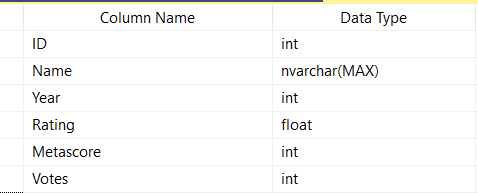

In [76]:
import pyodbc 
conn = pyodbc.connect('Driver={ODBC Driver 17 for SQL Server};'
                      'Server=DESKTOP-5MTG8IH;'
                      'Database=IMDB_rating_DB;'
                      'Trusted_Connection=yes;')

cursor = conn.cursor()
cursor.fast_executemany = True

In [77]:
cursor.executemany('INSERT INTO IMDB_rating_DB.dbo.Movies_tbl (Name,Year,Rating,Metascore,Votes) VALUES (?,?,?,?,?)', movie_df.values.tolist())

In [78]:
cursor.commit()
cursor.close()
conn.close()

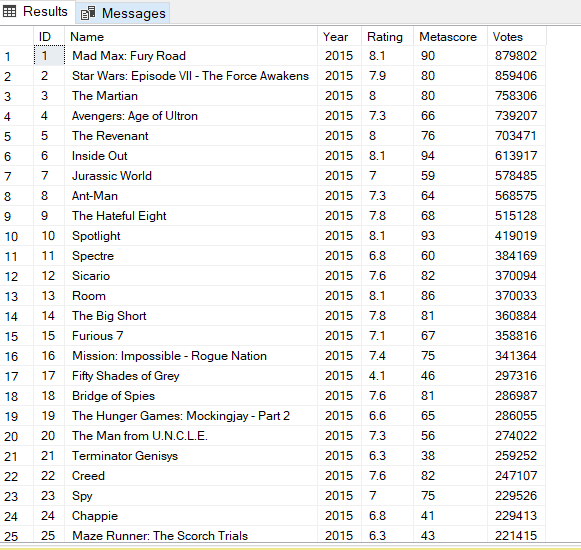